# Load MNIST Dataset

In [1]:
import tensorflow as tf 
from tensorflow.keras.datasets import mnist

import os 
import sys 
import numpy as np 
import matplotlib.pyplot as plt 

%matplotlib inline

np.random.seed(42)

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Train', x_train.shape, y_train.shape)
print('Test', x_test.shape, y_test.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


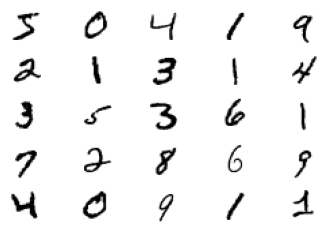

In [6]:
# plot raw pixel data
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(x_train[i], cmap='gray_r')

plt.show()


# Define Discriminator

In [7]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Flatten, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

In [9]:
def build_discriminator(in_shape=(28, 28, 1)):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), strides=2, padding='same', input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)

    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 128)        

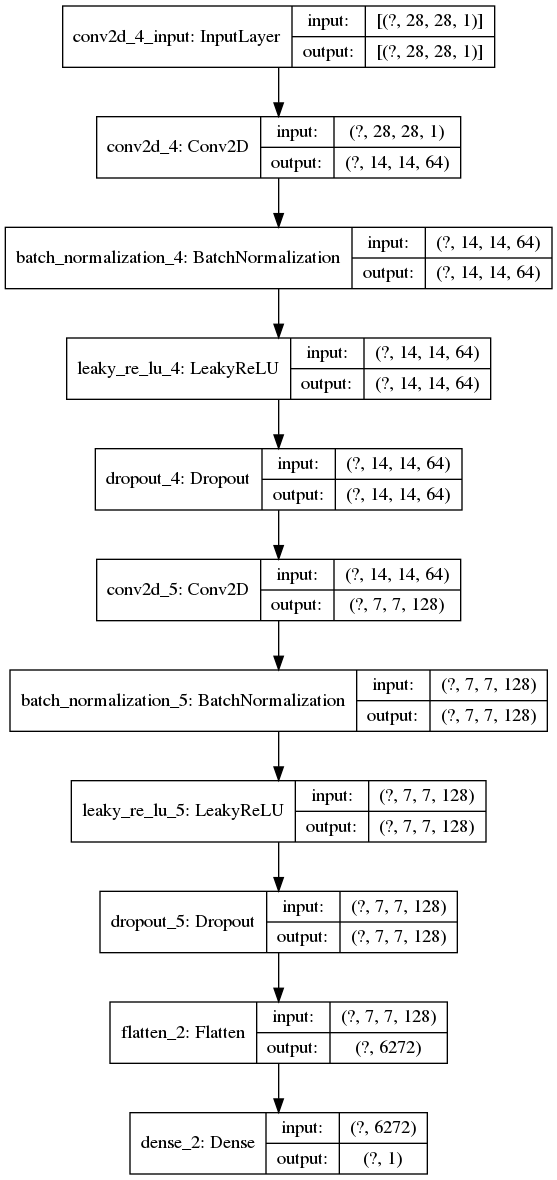

In [12]:
# define model 
disciminator = build_discriminator()
disciminator.summary()
plot_model(disciminator, to_file='images/discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
X_train = np.expand_dims(x_train, axis=3)
X_train = X_train / 255.0

print(X_train.shape)

(60000, 28, 28, 1)


In [15]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)

    X = dataset[ix]

    y = np.ones((n_samples, 1))

    return X, y

In [16]:
def generate_fake_samples(n_samples):
    X = np.random.rand(28 * 28 * n_samples)
    X = X.reshape((n_samples, 28, 28, 1))

    y = np.zeros((n_samples, 1))

    return X, y

In [33]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = n_batch // 2

    for i in range(n_iter):
        X_real, y_real = generate_real_samples(dataset, half_batch)

        _, real_acc = model.train_on_batch(X_real, y_real)

        X_fake, y_fake = generate_fake_samples(half_batch)

        _, fake_acc = model.train_on_batch(X_fake, y_fake)

        if i % 20 == 0:
            print('%.2d real=%.2f%% fake=%.2f%%' % (i+1, real_acc*100, fake_acc*100))


model = build_discriminator()

# fit the model 
train_discriminator(model, X_train)

01 real=33.59% fake=19.53%
21 real=100.00% fake=100.00%
41 real=100.00% fake=100.00%
61 real=100.00% fake=100.00%
81 real=100.00% fake=100.00%


# Define Generator


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 28, 28, 128)     

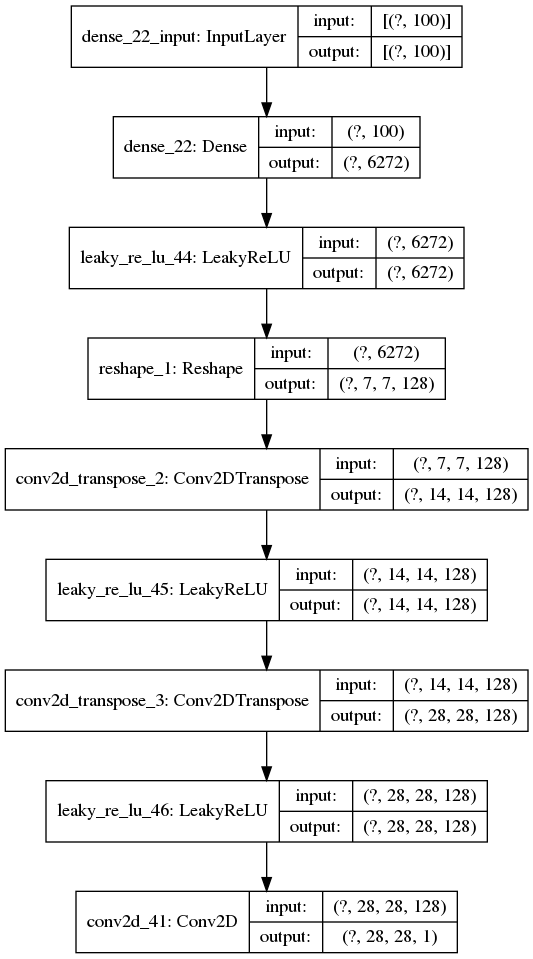

In [38]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose

def build_generator(latent_dim=100):
    model = Sequential()

    model.add(Dense(128 * 7 * 7, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))

    model.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(1, (7, 7), activation='sigmoid', padding='same'))

    return model

latent_dim = 100

model = build_generator(latent_dim=latent_dim)
model.summary()
plot_model(model, to_file='images/generator_plot.png', show_layer_names=True, show_shapes=True)


In [39]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)

    return x_input

In [47]:
def g_generator_fake_samples(model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)

    X = model.predict(x_input)
    y = np.zeros((n_samples, 1))

    return X, y

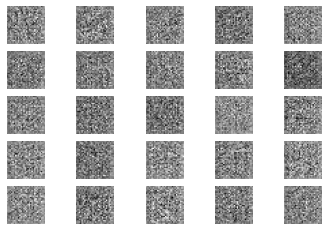

In [49]:
n_samples = 25

X, _ = g_generator_fake_samples(model, latent_dim, n_samples)

for i in range(n_samples):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(X[i, :, :, 0], cmap='gray_r')

plt.show()